In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torchmetrics
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import albumentations as A
import torch.nn.functional as F
import pandas as pd
import nibabel as nib
from tqdm import tqdm

2024-03-28 17:11:09.131633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 17:11:23.612128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Extract dataset

In [2]:
! ls BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/ | head -5

BraTS20_Training_001
BraTS20_Training_002
BraTS20_Training_003
BraTS20_Training_004
BraTS20_Training_005


In [3]:
! ls BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/

BraTS20_Training_001_flair.nii	BraTS20_Training_001_t1.nii
BraTS20_Training_001_seg.nii	BraTS20_Training_001_t2.nii
BraTS20_Training_001_t1ce.nii


In [4]:
root = './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
data = pd.read_csv(os.path.join(root, 'name_mapping.csv'))
data.head(5)

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [5]:
imgpath = {
    'seg': [],    
    't1': [],
    't1ce': [],
    't2': [],
    'flair': []
}

# load image paths in dictionary
for x in data['BraTS_2020_subject_ID']:
    patient=os.path.join(root,x)
    for name in imgpath:
        imgpath[name].append(os.path.join(patient, x+f'_{name}.nii'))
imgpath['seg'][:5]

['./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii',
 './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii',
 './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii',
 './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_004/BraTS20_Training_004_seg.nii',
 './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_seg.nii']

In [6]:
def loadimg(imgpath):
    return nib.load(imgpath).get_fdata()

def cropcentre(imgslice,cropx,cropy):
    y,x = imgslice.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return imgslice[starty:starty+cropy,startx:startx+cropx]

def normalizeslice(imgslice):
    return (imgslice-imgslice.mean()) / imgslice.std()

In [45]:
! mkdir dataset
! mkdir dataset/t1
! mkdir dataset/t1ce
! mkdir dataset/t2
! mkdir dataset/flair
! mkdir dataset/seg

mkdir: cannot create directory ‘dataset’: File exists
mkdir: cannot create directory ‘dataset/t1’: File exists
mkdir: cannot create directory ‘dataset/t1ce’: File exists
mkdir: cannot create directory ‘dataset/t2’: File exists
mkdir: cannot create directory ‘dataset/flair’: File exists
mkdir: cannot create directory ‘dataset/seg’: File exists


In [46]:
numOfImgsSaved = 0
imgs = {}
imgslice = {}
imagestosave = 6000

for i in (range(len(imgpath['seg']))):
    if numOfImgsSaved >= imagestosave:
        break
    for name in imgpath:
        imgs[name] = loadimg(imgpath[name][i])
    
    for j in range(155):
        if numOfImgsSaved >= imagestosave:
            break
        for name in imgs:
            imgslice[name] = imgs[name][:,:,j]
            imgslice[name] = cropcentre(imgslice[name], 192, 192)

        if imgslice['seg'].max() > 0:
            for name in ['t1','t2','t1ce','flair']:
                imgslice[name] = normalizeslice(imgslice[name])
            for name in imgslice:
                np.save(f'./dataset/{name}/img_{numOfImgsSaved}.npy', imgslice[name])
            numOfImgsSaved += 1



In [7]:
! du -h dataset

3.3G	dataset/t1ce
3.3G	dataset/t2
3.3G	dataset/t1
3.3G	dataset/flair
2.8G	dataset/seg
16G	dataset


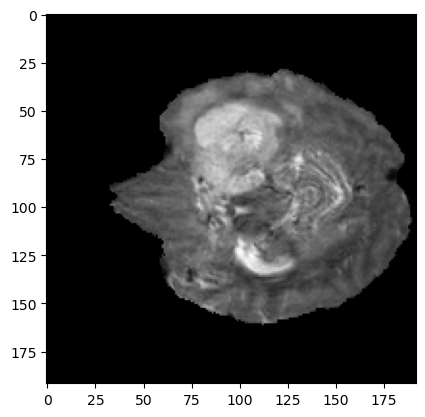

In [8]:
x = np.load('dataset/t2/img_25.npy')
plt.imshow(x, cmap='gray')

# Dataset

In [2]:
class Dataset(Dataset):
    def __init__(self, datapath='./dataset/', augmentation=None):
        self.augmentation = augmentation
        self.folderpaths = {
            'mask': os.path.join(datapath, 'seg/'),
            't1': os.path.join(datapath, 't1/'),
            't1ce': os.path.join(datapath, 't1ce/'),
            't2': os.path.join(datapath, 't2/'),
            'flair': os.path.join(datapath, 'flair/')
        }
    
    def __getitem__(self, idx):
        images = {}
        for name in self.folderpaths:
            images[name] = np.load(os.path.join(self.folderpaths[name], f'img_{idx}.npy'))

        if self.augmentation:
            images = self.augmentation(image=images['flair'],
                                      mask=images['mask'],
                                      t1=images['t1'],
                                      t1ce=images['t1ce'],
                                      t2=images['t2'])
            images['flair'] = images['image']

        for name in images:
            images[name] = torch.from_numpy(images[name])

        # stack modalities
        input = torch.stack([images['t1'],
                             images['t1ce'],
                             images['t2'],
                             images['flair']], dim=0)
        
        # map pixels with value of 4 to 3
        images['mask'][images['mask']==4] = 3

        # one-hot encode truth label
        images['mask'] = F.one_hot(images['mask'].long().unsqueeze(0), num_classes = 4).permute(0,3,1,2).contiguous().squeeze(0)

        return input.float(), images['mask'].long()
    
    def __len__(self):
        return len(os.listdir(self.folderpaths['mask'])) - 1

In [3]:
augmentation = A.Compose([
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5)                  
        ], p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    ], 
    additional_targets={'t1':'image',
                          't1ce':'image',
                          't2':'image'})

valid_test_dataset = Dataset(datapath='./dataset/',
                             augmentation=None)

train_dataset = Dataset(datapath='./dataset/',
                        augmentation=augmentation)

train_length=int(0.6 * len(valid_test_dataset))
valid_length = int(0.2 * len(valid_test_dataset))
test_length = len(valid_test_dataset) - train_length - valid_length

_, valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))

train_dataset, _, _ = torch.utils.data.random_split(train_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))


train_loader= DataLoader(train_dataset,
                      batch_size=16,
                      shuffle=True)

valid_loader= DataLoader(valid_dataset,
                      batch_size=16,
                      shuffle=False)

test_loader= DataLoader(test_dataset,
                      batch_size=16,
                      shuffle=False)

In [4]:
a,b=next(iter(train_loader))

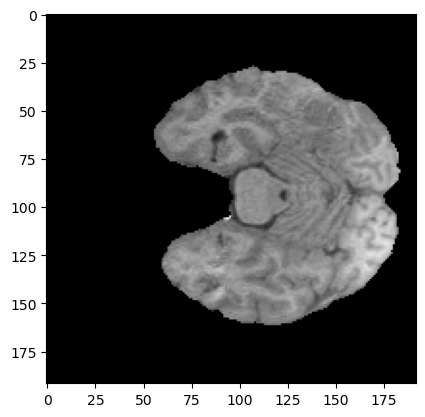

In [5]:
plt.imshow(a[0,0],cmap='gray')

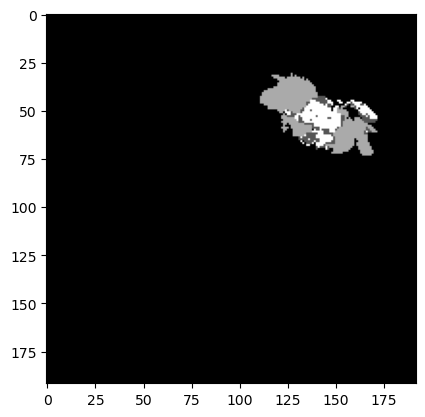

In [6]:
bb = torch.argmax(b,1)
plt.imshow(bb[0],cmap='gray')

# Train Model

In [7]:
torch.cuda.empty_cache()

In [8]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Wed Mar 20 12:31:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:84:00.0 Off |                  N/A |
| 29%   31C    P8              22W / 250W |     15MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
class Squeeze_Excitation(nn.Module):
    def __init__(self, channel, r=8):
        super().__init__()

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.net = nn.Sequential(
            nn.Linear(channel, channel // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // r, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        b, c, _, _ = inputs.shape
        x = self.pool(inputs).view(b, c)
        x = self.net(x).view(b, c, 1, 1)
        x = inputs * x
        return x

class Stem_Block(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(out_c),
        )

        self.attn = Squeeze_Excitation(out_c)

    def forward(self, inputs):
        x = self.c1(inputs)
        s = self.c2(inputs)
        y = self.attn(x + s)
        return y

class ResNet_Block(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.ReLU(),
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(out_c),
        )

        self.attn = Squeeze_Excitation(out_c)

    def forward(self, inputs):
        x = self.c1(inputs)
        s = self.c2(inputs)
        y = self.attn(x + s)
        return y

class ASPP(nn.Module):
    def __init__(self, in_c, out_c, rate=[1, 6, 12, 18]):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[0], padding=rate[0]),
            nn.BatchNorm2d(out_c)
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[1], padding=rate[1]),
            nn.BatchNorm2d(out_c)
        )

        self.c3 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[2], padding=rate[2]),
            nn.BatchNorm2d(out_c)
        )

        self.c4 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[3], padding=rate[3]),
            nn.BatchNorm2d(out_c)
        )

        self.c5 = nn.Conv2d(out_c, out_c, kernel_size=1, padding=0)


    def forward(self, inputs):
        x1 = self.c1(inputs)
        x2 = self.c2(inputs)
        x3 = self.c3(inputs)
        x4 = self.c4(inputs)
        x = x1 + x2 + x3 + x4
        y = self.c5(x)
        return y

class Attention_Block(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        out_c = in_c[1]

        self.g_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[0]),
            nn.ReLU(),
            nn.Conv2d(in_c[0], out_c, kernel_size=3, padding=1),
            nn.MaxPool2d((2, 2))
        )

        self.x_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[1]),
            nn.ReLU(),
            nn.Conv2d(in_c[1], out_c, kernel_size=3, padding=1),
        )

        self.gc_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[1]),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        )

    def forward(self, g, x):
        g_pool = self.g_conv(g)
        x_conv = self.x_conv(x)
        gc_sum = g_pool + x_conv
        gc_conv = self.gc_conv(gc_sum)
        y = gc_conv * x
        return y

class Decoder_Block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.a1 = Attention_Block(in_c)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.r1 = ResNet_Block(in_c[0]+in_c[1], out_c, stride=1)

    def forward(self, g, x):
        d = self.a1(g, x)
        d = self.up(d)
        d = torch.cat([d, g], axis=1)
        d = self.r1(d)
        return d

class resunetplusplus(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = Stem_Block(4, 16, stride=1)
        self.c2 = ResNet_Block(16, 32, stride=2)
        self.c3 = ResNet_Block(32, 64, stride=2)
        self.c4 = ResNet_Block(64, 128, stride=2)

        self.b1 = ASPP(128, 256)

        self.d1 = Decoder_Block([64, 256], 128)
        self.d2 = Decoder_Block([32, 128], 64)
        self.d3 = Decoder_Block([16, 64], 32)

        self.aspp = ASPP(32, 16)
        self.output = nn.Conv2d(16, 4, kernel_size=1, padding=0)

    def forward(self, inputs):
        c1 = self.c1(inputs)
        c2 = self.c2(c1)
        c3 = self.c3(c2)
        c4 = self.c4(c3)

        b1 = self.b1(c4)

        d1 = self.d1(c3, b1)
        d2 = self.d2(c2, d1)
        d3 = self.d3(c1, d2)

        output = self.aspp(d3)
        output = self.output(output)

        return output

In [10]:
class DiceLoss(nn.Module):
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability[:, 1:, ...]  # Exclude the first channel
        probability = probability.contiguous().view(num, -1)
        targets = targets[:, 1:, ...]  # Exclude the first channel
        targets = targets.contiguous().view(num, -1)

        assert probability.shape == targets.shape, "Probability and target shapes do not match"

        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / (union + self.eps)

        return 1.0 - dice_score
    
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        # logits are the images 
        # target are the masks 
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets.float())
        
        # binary cross entropy loss & dice loss 
        return bce_loss + dice_loss

In [11]:
# Define the training loop
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    epoch_loss = 0
    bce_dice_loss = BCEDiceLoss().to(device)
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = bce_dice_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"\rBatch Loss: {loss.item():.4f}", end="")
    return epoch_loss / len(data_loader)

# Define the validation loop
def validate(model, data_loader, device, num_classes):
    model.eval()
    epoch_loss = 0
    bce_dice_loss = BCEDiceLoss().to(device)
    dice_loss = DiceLoss().to(device)
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = bce_dice_loss(outputs, targets)
            loss_dice = dice_loss(outputs, targets)
            epoch_loss += loss.item()
            print(f"\rVal Batch Loss: {loss.item():.4f}", end="")

        d_loss = loss_dice.item()
        dice_score = 1 - d_loss
    return epoch_loss / len(data_loader), dice_score


# Training and validation loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resunetplusplus().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
num_classes = 4

stats = {
    'train_loss': [],
    'valid_loss': [],
    'dice_score': []
}

for epoch in range(20):
    print(f'\n --- Epoch {epoch} --- ')

    # Training
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    print(f'Train Loss: {train_loss:.4f}')

    # Validation
    valid_loss, dice_score = validate(model, valid_loader, device, num_classes)
    print(f'Valid Loss: {valid_loss:.4f}, Dice Score: {dice_score:.4f}')

    # Update learning rate
    #scheduler.step()

    # Update statistics
    stats['train_loss'].append(train_loss)
    stats['valid_loss'].append(valid_loss)
    stats['dice_score'].append(dice_score)

    # Save model statistics
    np.save('./resunet++_model.npy', stats)
    
    model_path = 'resunet_models/model.pth'
    torch.save(model.state_dict(), model_path)


 --- Epoch 0 --- 
Batch Loss: 1.3995Train Loss: 1.5242
Val Batch Loss: 1.4266Valid Loss: 1.4245, Dice Score: 0.0408

 --- Epoch 1 --- 
Batch Loss: 1.2717Train Loss: 1.3610
Val Batch Loss: 1.2888Valid Loss: 1.2881, Dice Score: 0.0540

 --- Epoch 2 --- 
Batch Loss: 1.1165Train Loss: 1.1885
Val Batch Loss: 1.0968Valid Loss: 1.0898, Dice Score: 0.0875

 --- Epoch 3 --- 
Batch Loss: 0.8919Train Loss: 0.9915
Val Batch Loss: 0.8643Valid Loss: 0.8488, Dice Score: 0.2103

 --- Epoch 4 --- 
Batch Loss: 0.3959Train Loss: 0.6757
Val Batch Loss: 0.4567Valid Loss: 0.4451, Dice Score: 0.5733

 --- Epoch 5 --- 
Batch Loss: 0.2828Train Loss: 0.3895
Val Batch Loss: 0.2585Valid Loss: 0.2589, Dice Score: 0.7584

 --- Epoch 6 --- 
Batch Loss: 0.2648Train Loss: 0.2973
Val Batch Loss: 0.2185Valid Loss: 0.2177, Dice Score: 0.7994

 --- Epoch 7 --- 
Batch Loss: 0.3423Train Loss: 0.2628
Val Batch Loss: 0.1709Valid Loss: 0.1975, Dice Score: 0.8441

 --- Epoch 8 --- 
Batch Loss: 0.3062Train Loss: 0.2557
Val Batc

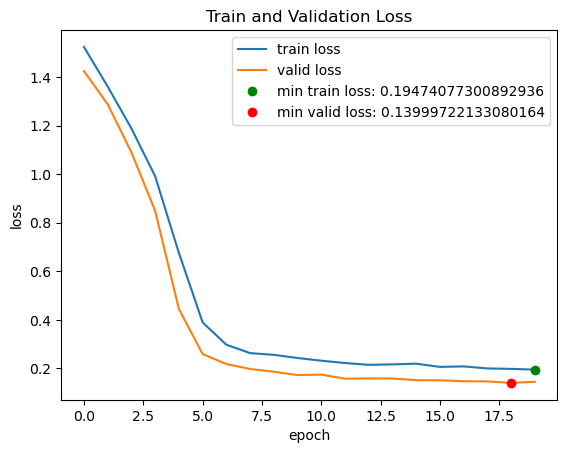

In [8]:
# Load the STATS dictionary
STATS = np.load(f'./resunet++_model.npy', allow_pickle='TRUE').item()

train_loss = STATS['train_loss']
valid_loss = STATS['valid_loss']

# Find the lowest train and validation loss
min_train_loss = min(train_loss)
min_valid_loss = min(valid_loss)

min_train_loss_epoch = train_loss.index(min_train_loss)
min_valid_loss_epoch = valid_loss.index(min_valid_loss)

plt.plot(train_loss, label='train loss')
plt.plot(valid_loss, label='valid loss')

# Display the minimum and maximum losses
plt.plot(min_train_loss_epoch, min_train_loss, 'go', label=f'min train loss: {min_train_loss}')
plt.plot(min_valid_loss_epoch, min_valid_loss, 'ro', label=f'min valid loss: {min_valid_loss}')

plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train and Validation Loss')

plt.show()

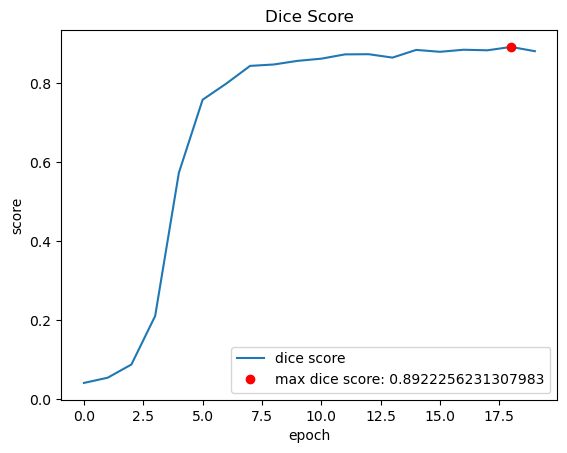

In [9]:
plt.plot(STATS['dice_score'], label='dice score')

# Display the maximum dice score
max_dice_score = max(STATS['dice_score'])
max_dice_score_epoch = STATS['dice_score'].index(max_dice_score)

plt.plot(max_dice_score_epoch, max_dice_score, 'ro', label=f'max dice score: {max_dice_score}')

# Add labels and title
plt.legend(loc="lower right")
plt.ylabel('score')
plt.xlabel('epoch')
plt.title('Dice Score')

# Show the plot
plt.show()

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resunetplusplus().to(device)
model.load_state_dict(torch.load('resunet_models/model.pth'))

<All keys matched successfully>

In [19]:
a,b=next(iter(train_loader))
outputs = model(a.cuda())
predicted_mask = torch.sigmoid(outputs)
predicted_mask_cpu = predicted_mask.cpu().detach().numpy()

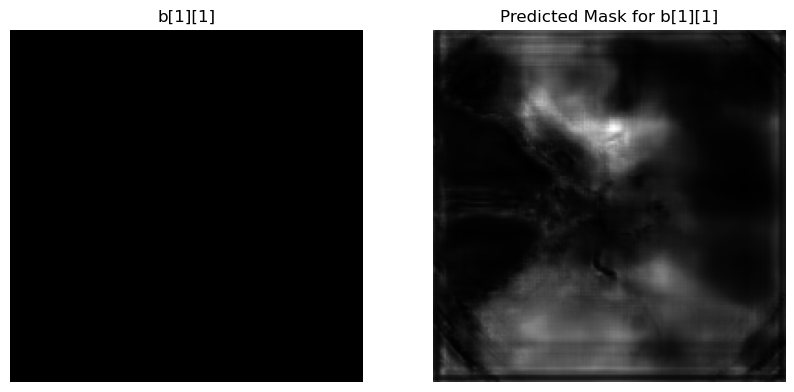

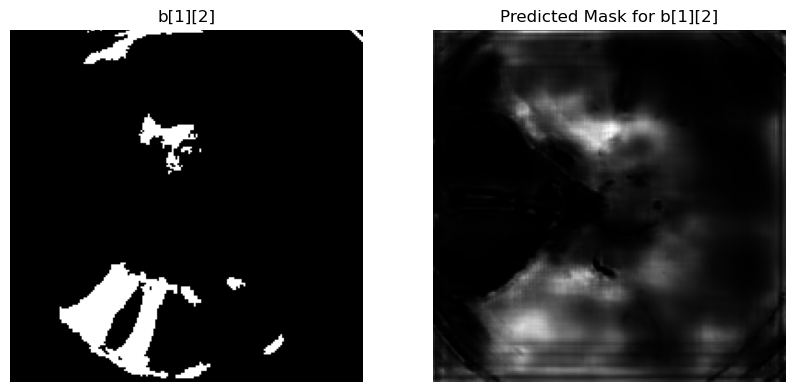

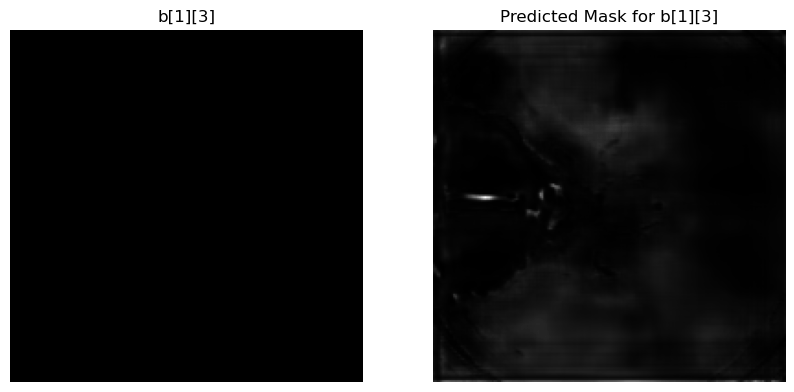

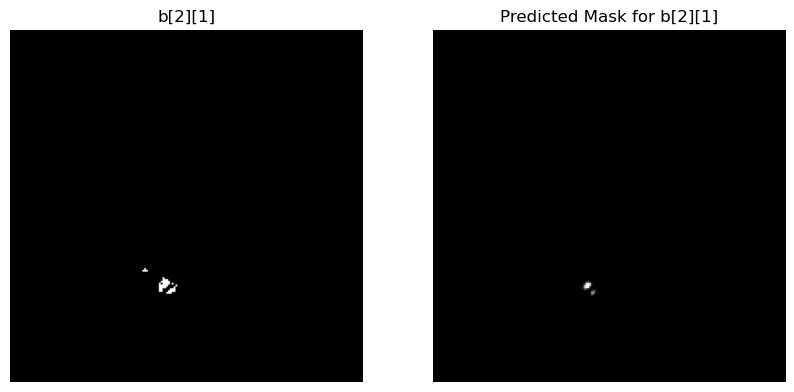

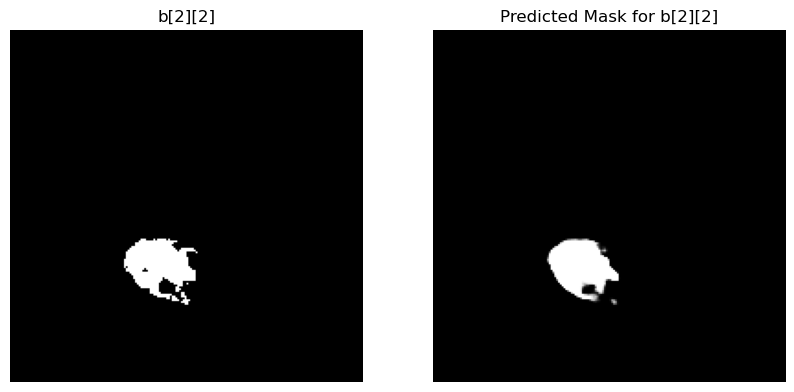

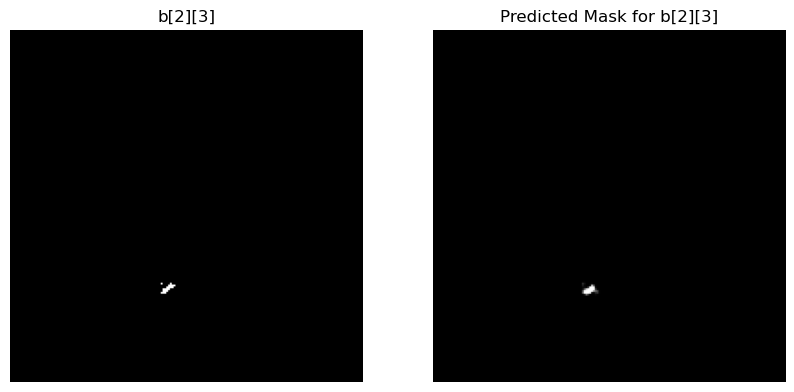

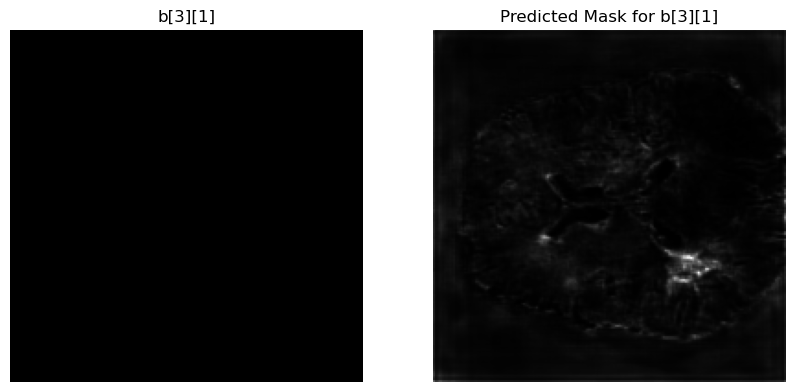

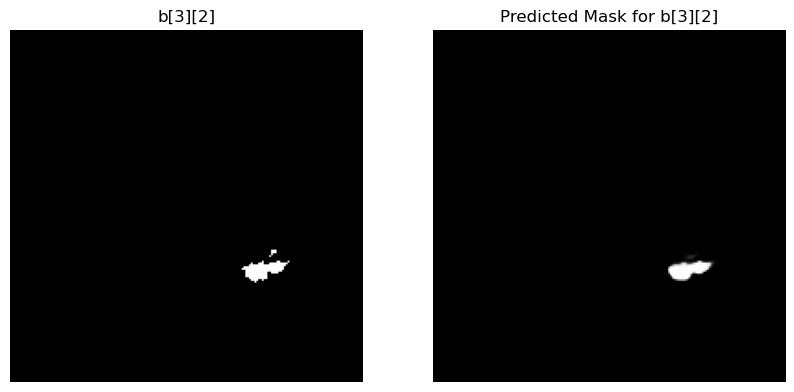

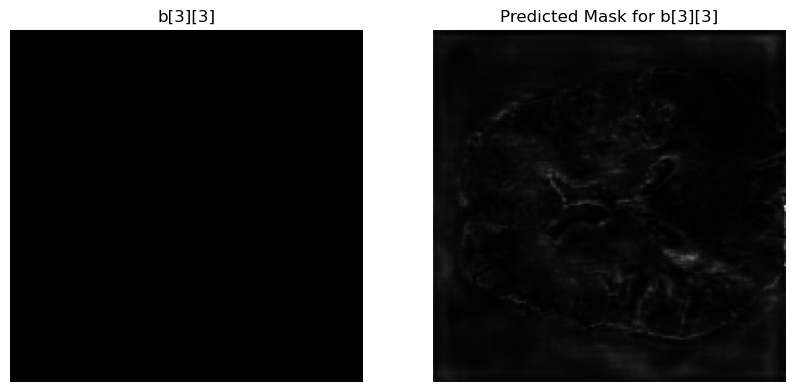

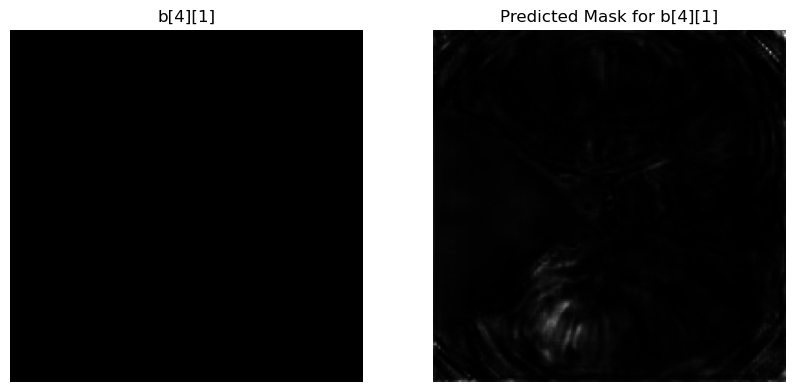

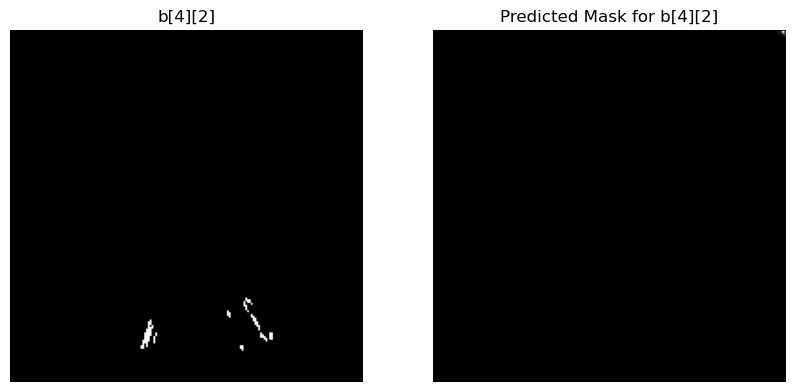

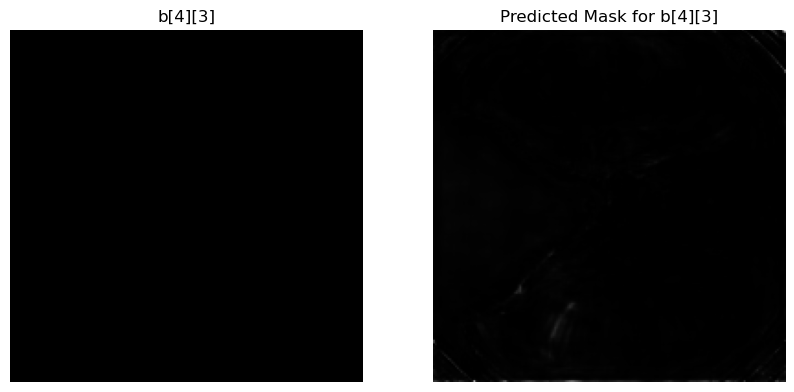

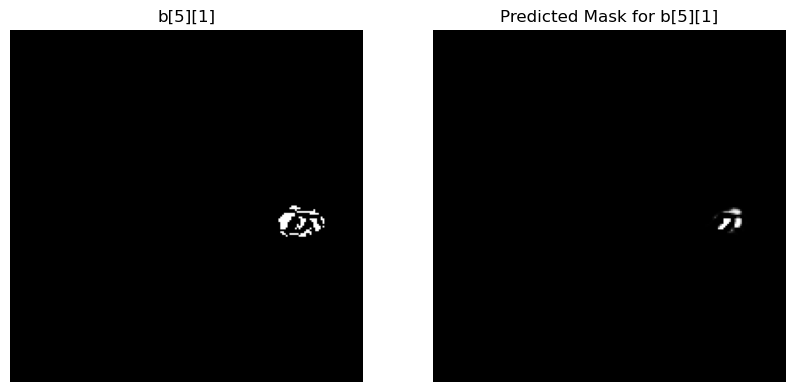

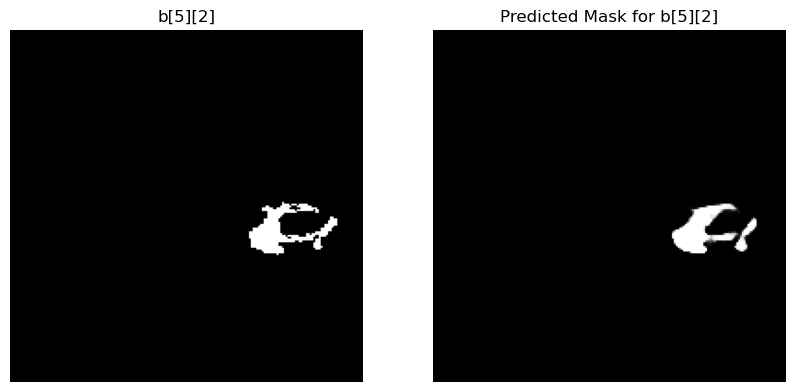

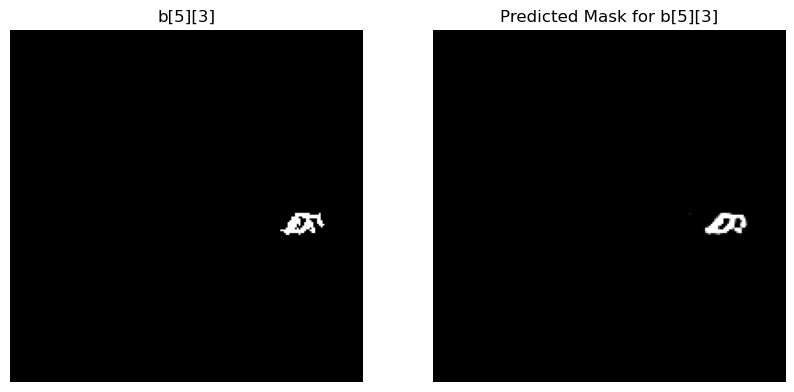

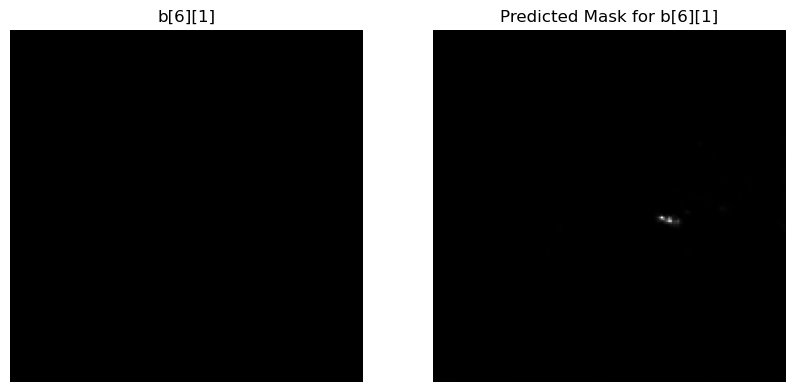

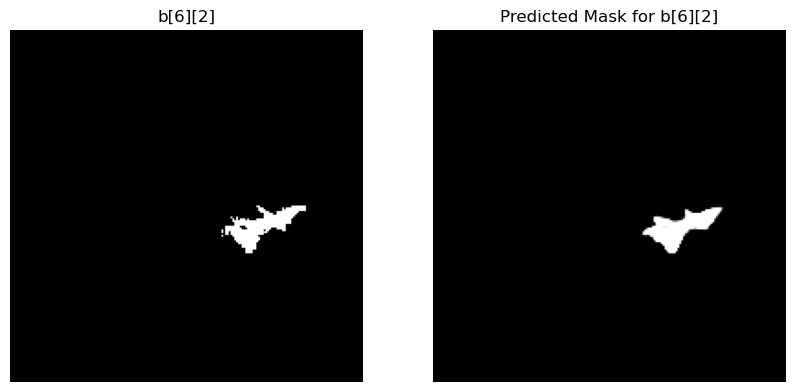

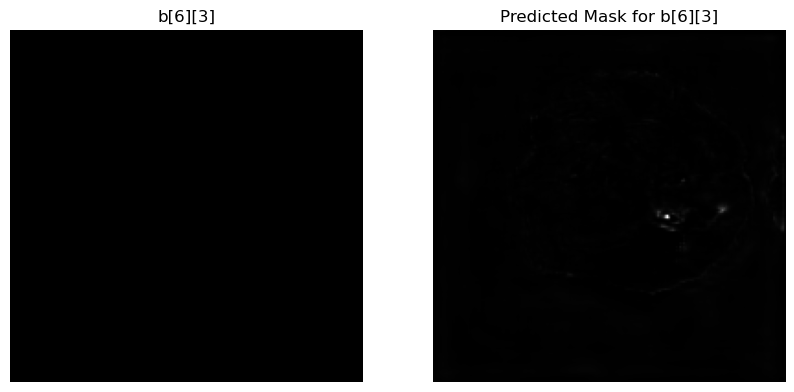

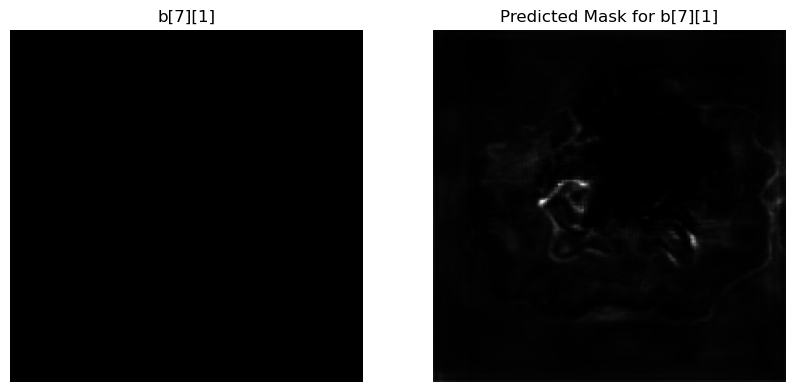

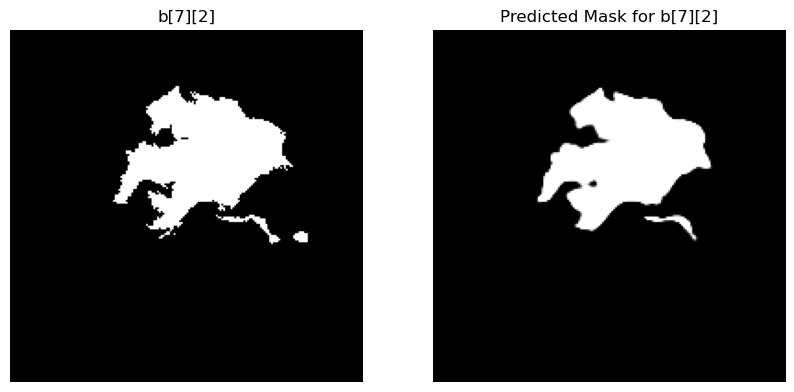

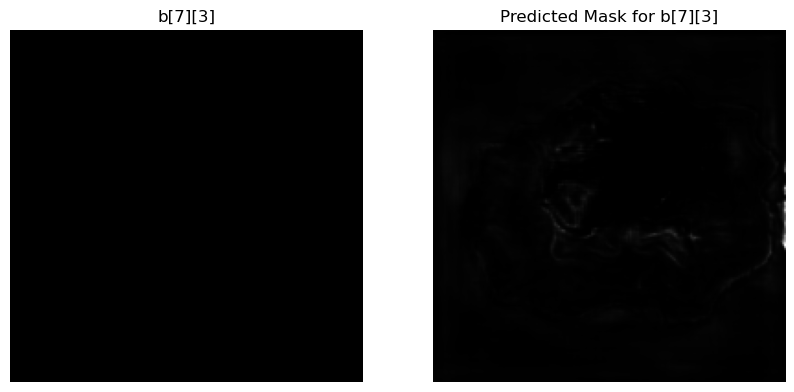

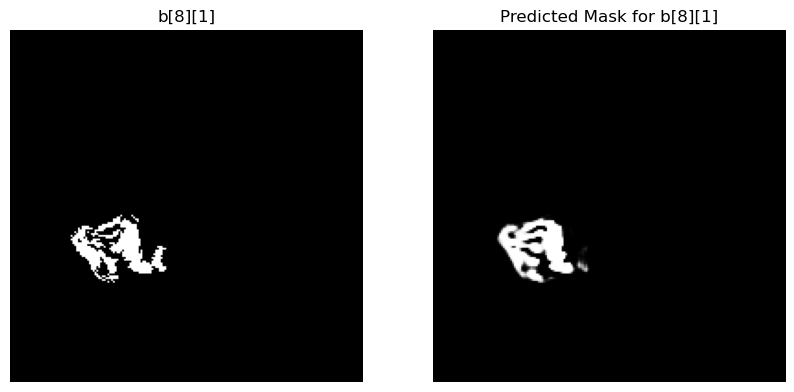

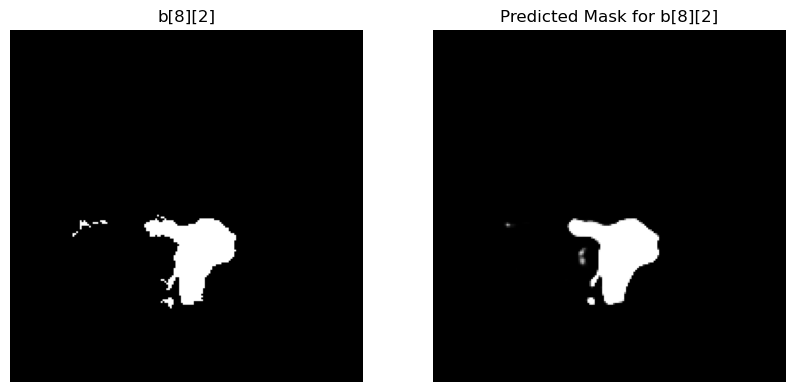

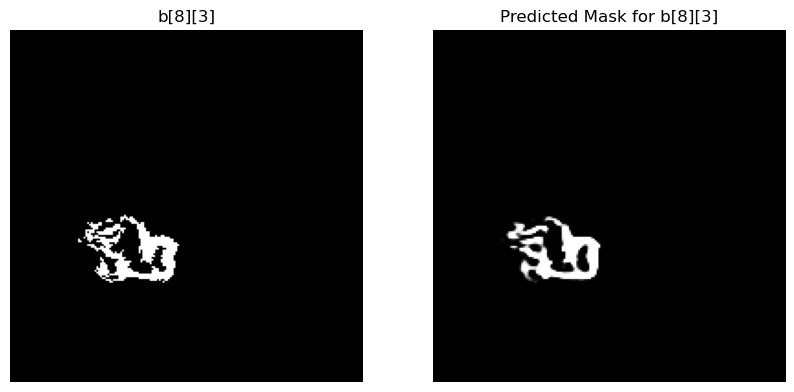

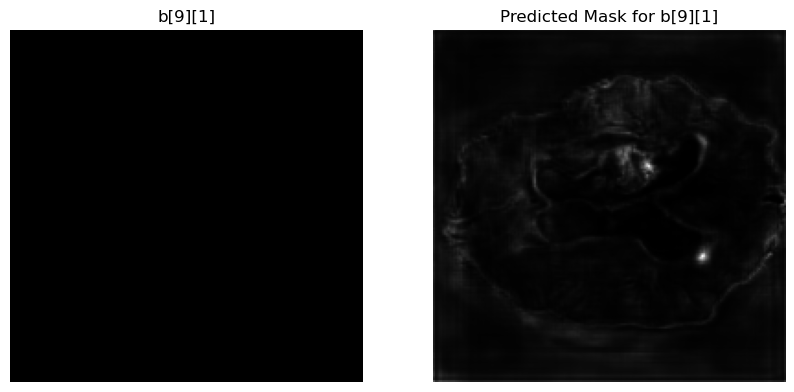

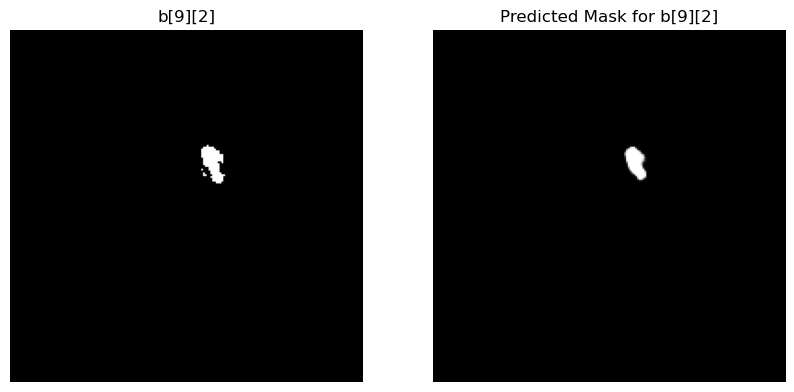

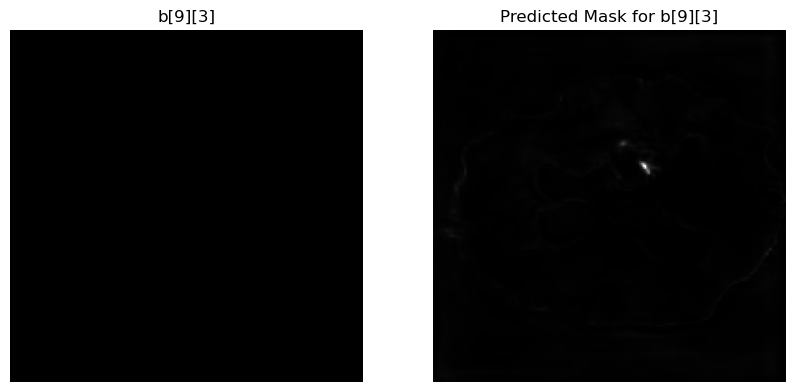

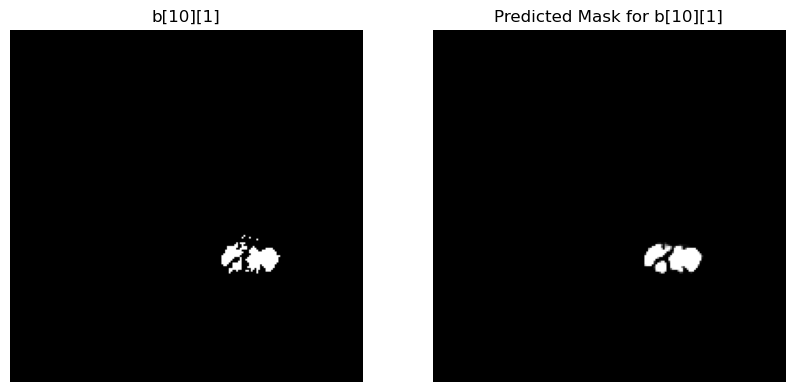

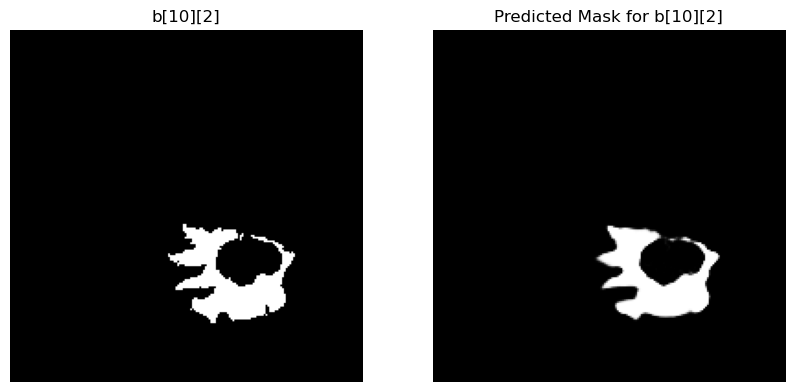

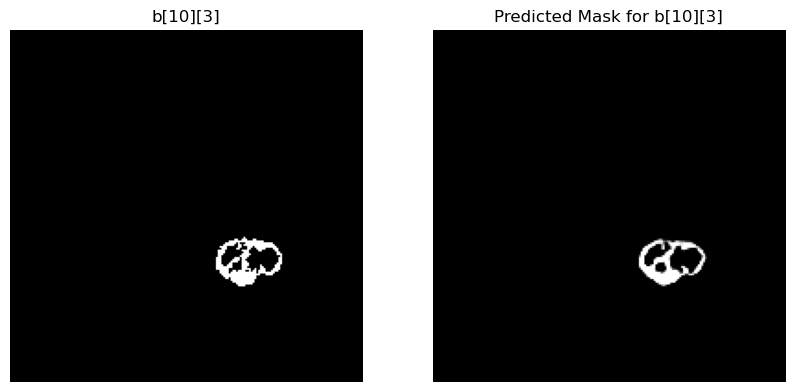

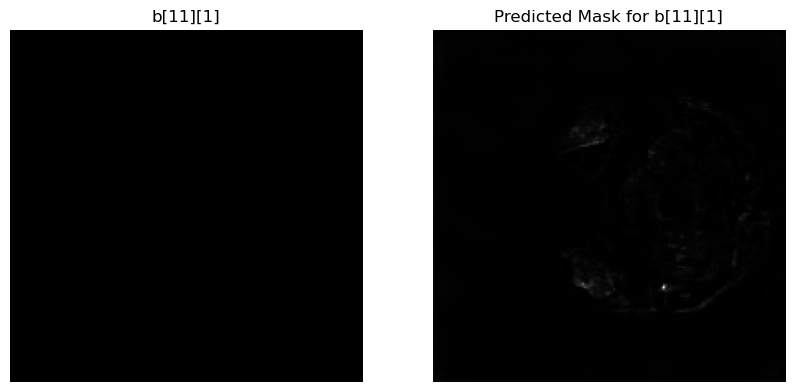

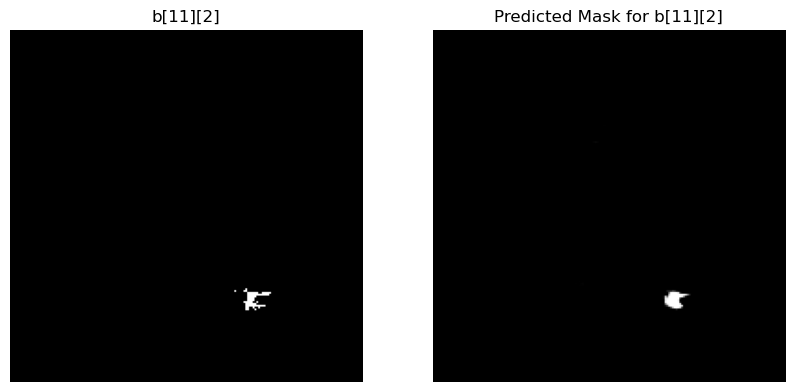

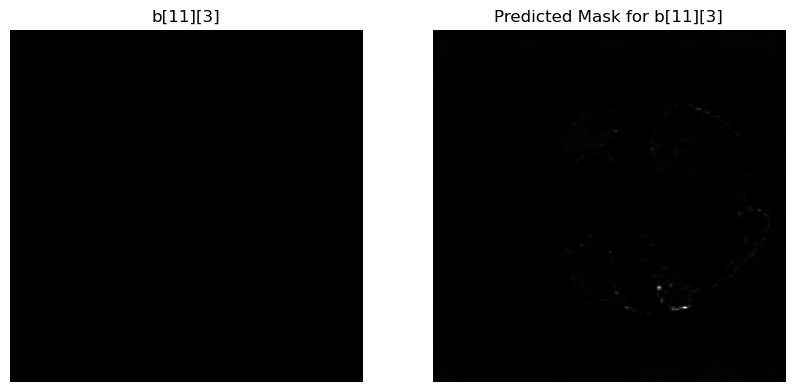

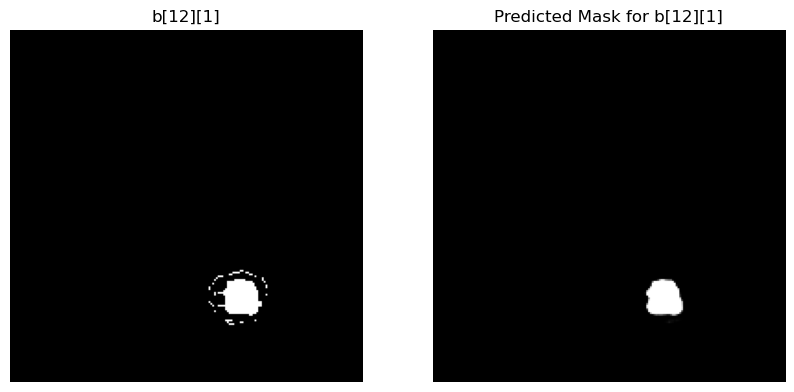

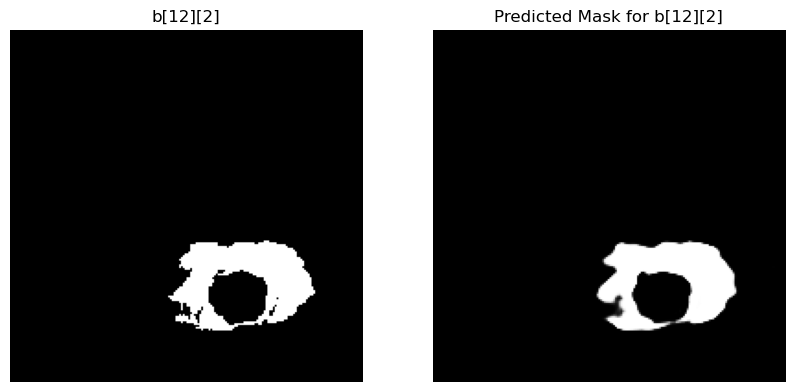

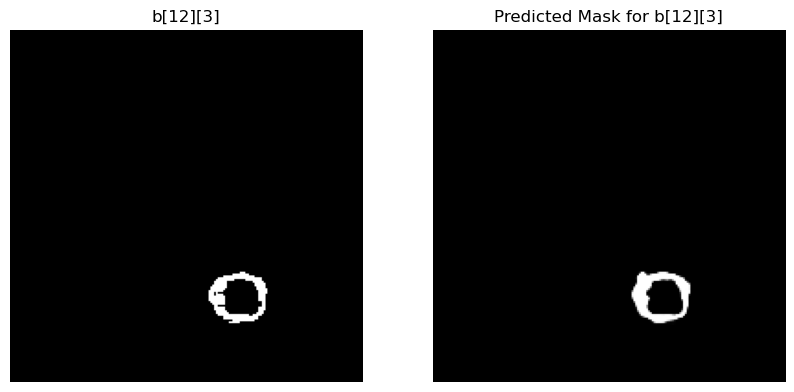

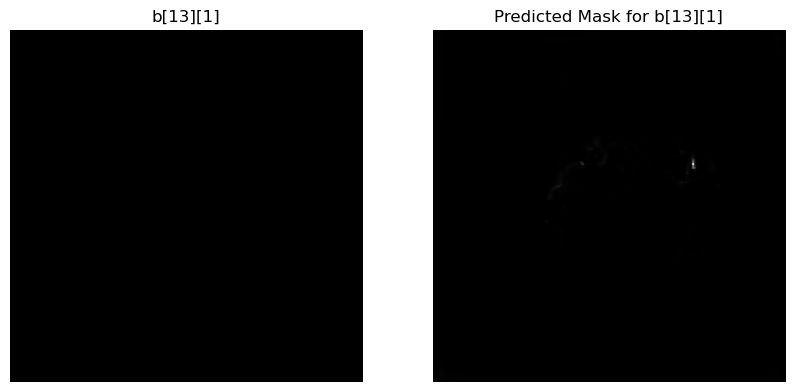

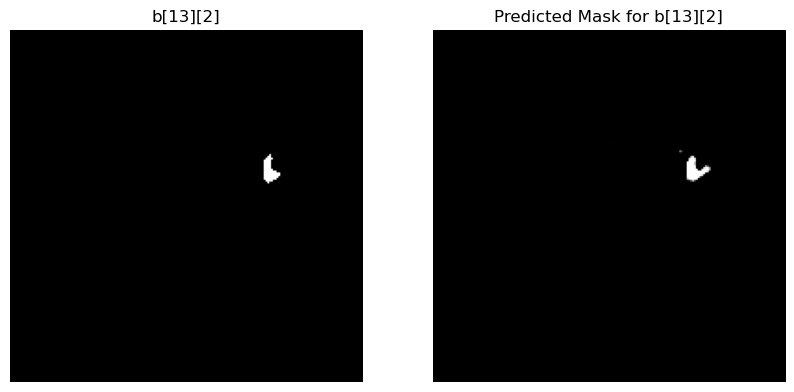

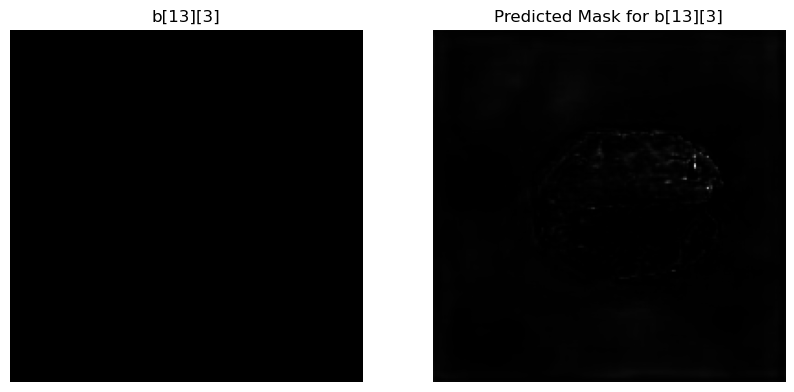

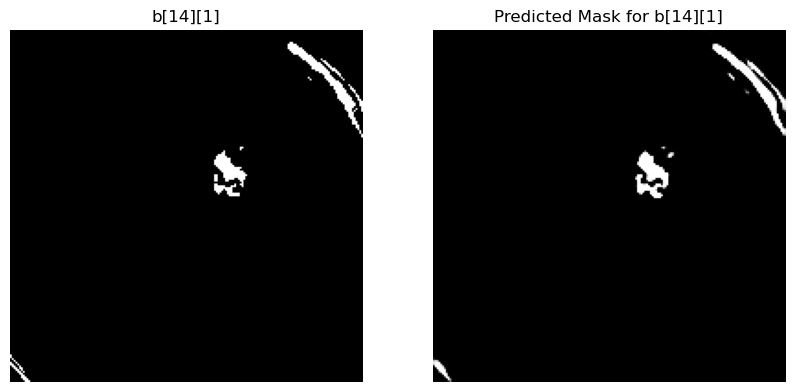

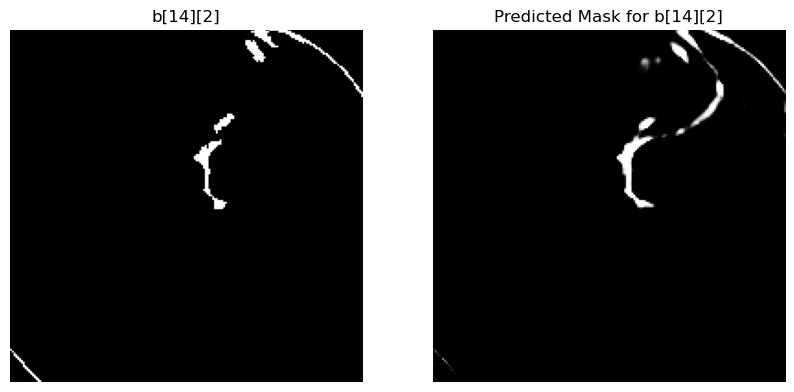

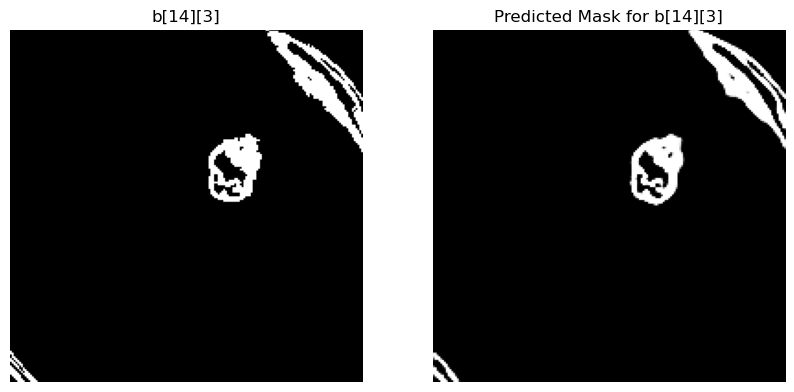

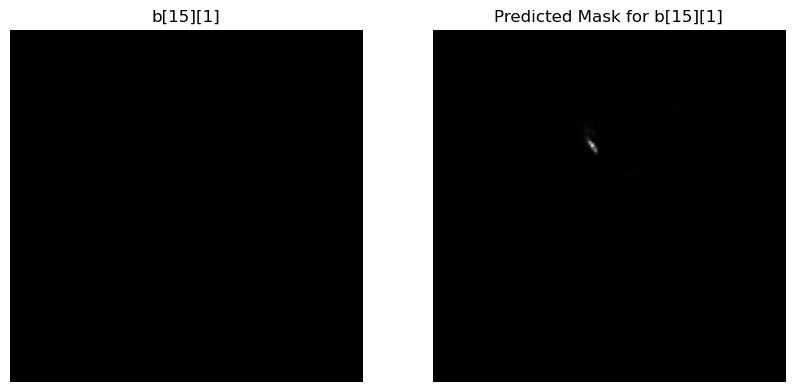

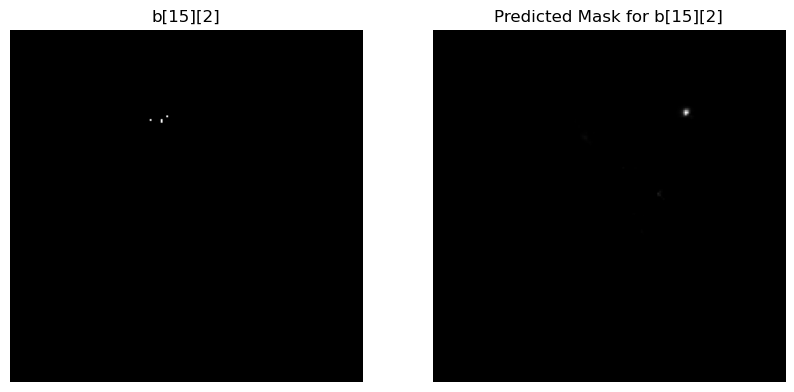

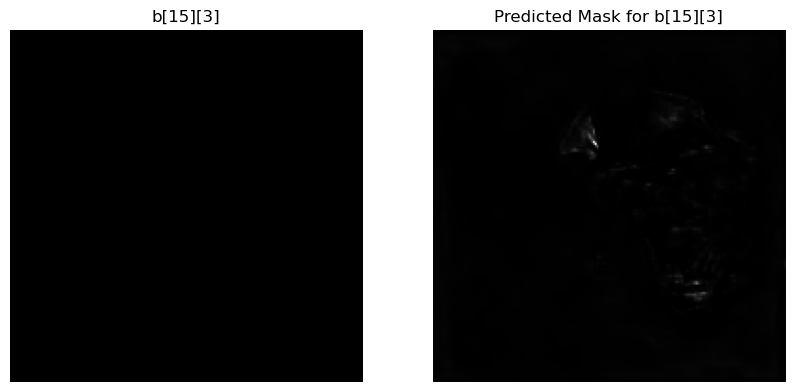

In [20]:
for i in range(1,len(b)):
    for j in range(1,len(b[i])):
        plt.figure(figsize=(10, 5))

        # Plot b[i][j]
        plt.subplot(1, 2, 1)
        plt.imshow(b[i][j], cmap="gray")
        plt.title(f"b[{i}][{j}]")
        plt.axis('off')

        # Plot predicted_mask_cpu[i][j]
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_mask_cpu[i][j], cmap="gray")
        plt.title(f"Predicted Mask for b[{i}][{j}]")
        plt.axis('off')

        plt.show()


# Test Model

In [22]:
a,b=next(iter(test_loader))
outputs = model(a.cuda())
predicted_mask = torch.sigmoid(outputs)
predicted_mask_cpu = predicted_mask.cpu().detach().numpy()

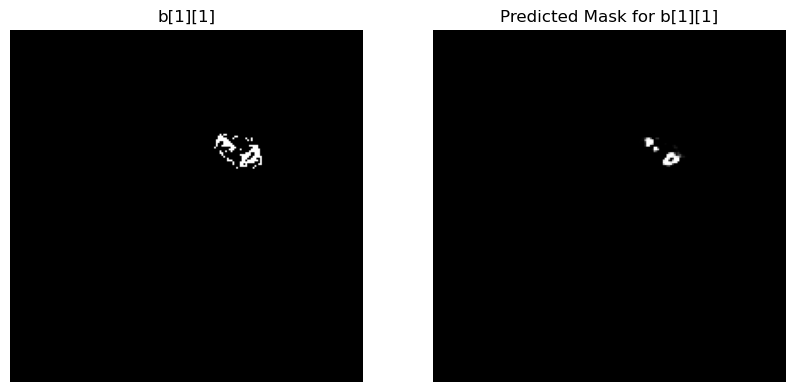

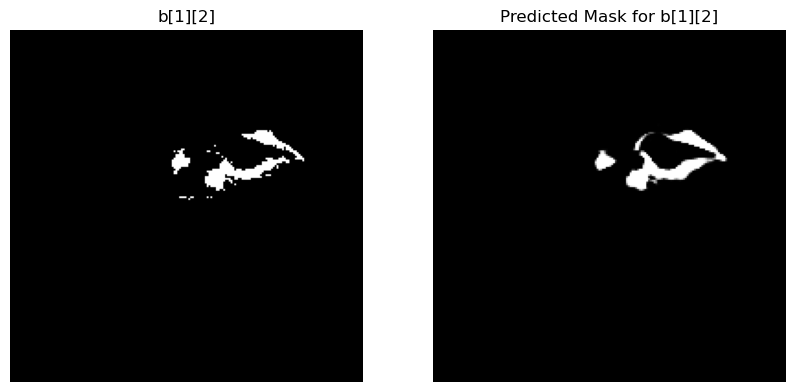

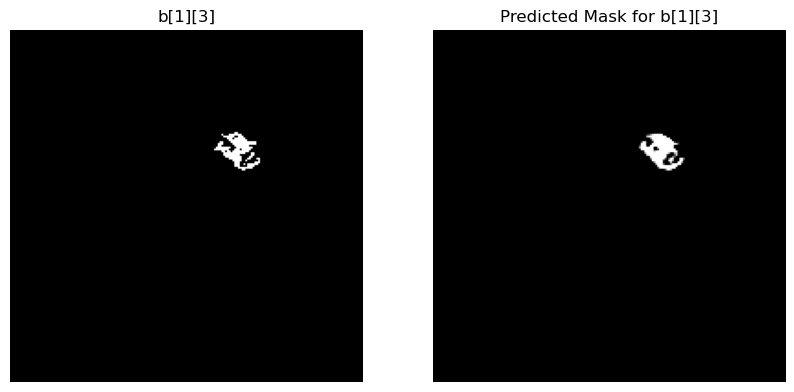

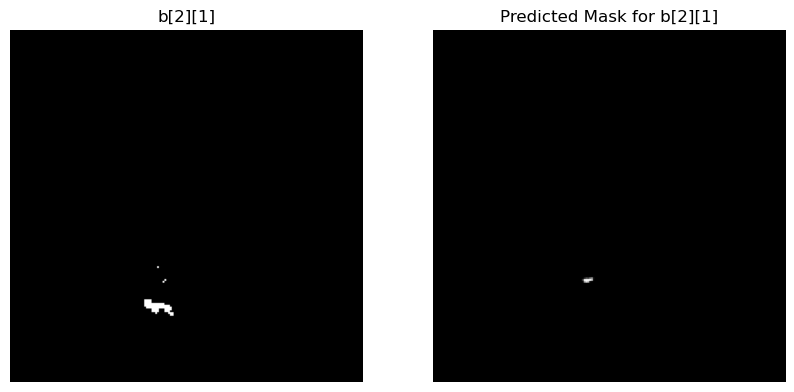

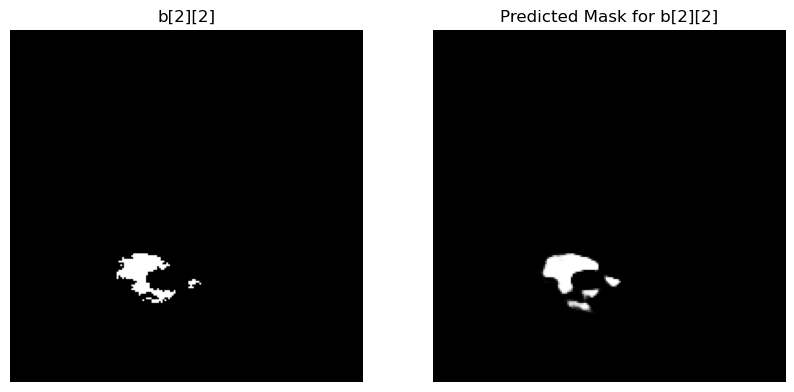

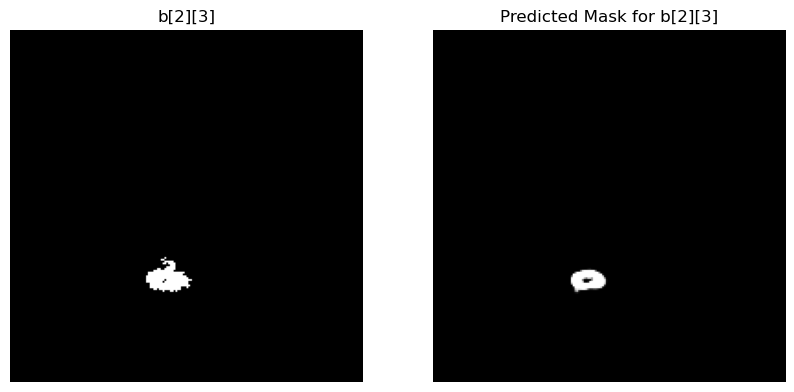

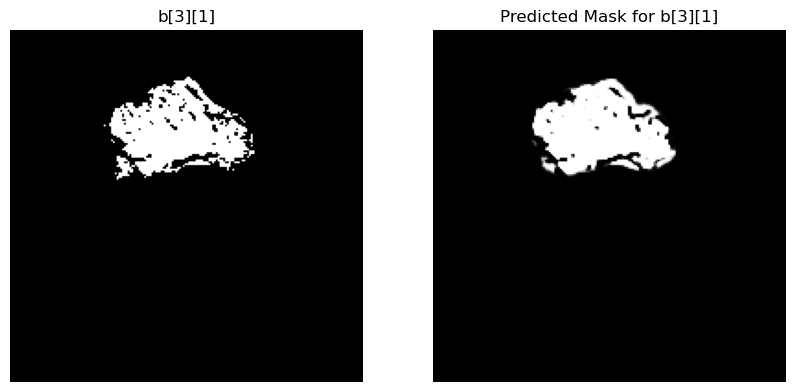

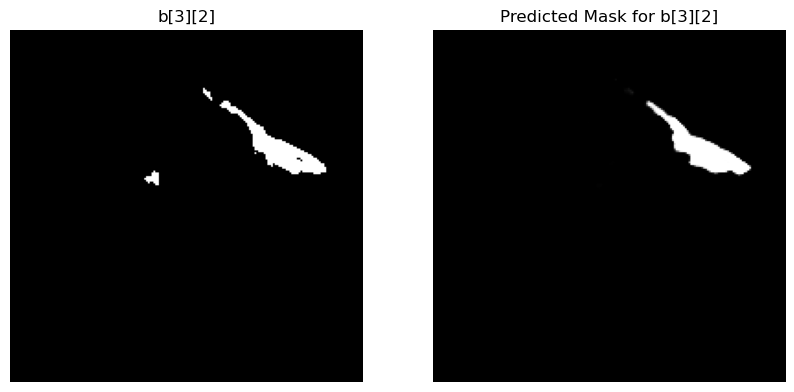

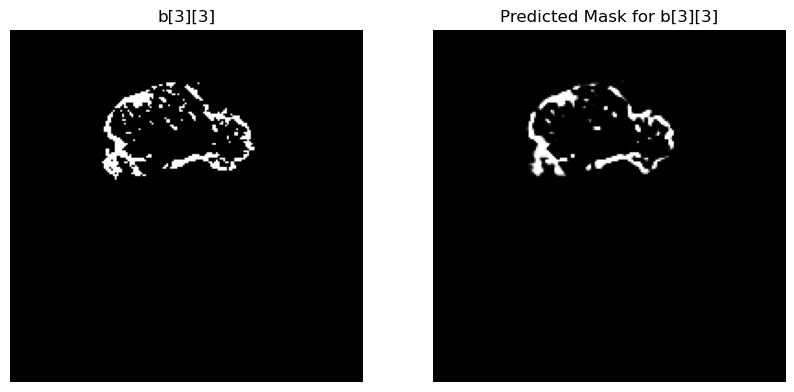

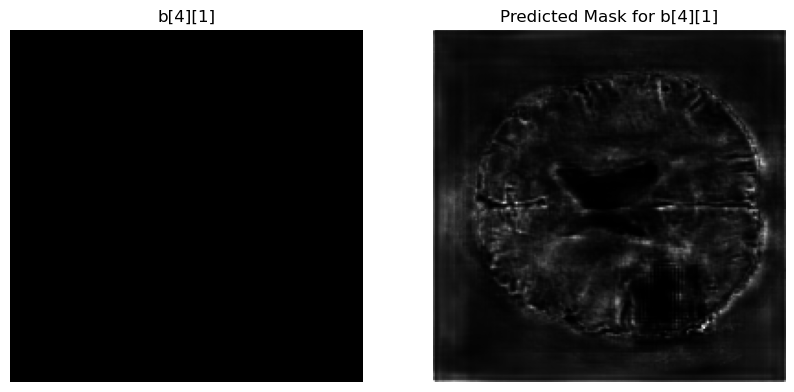

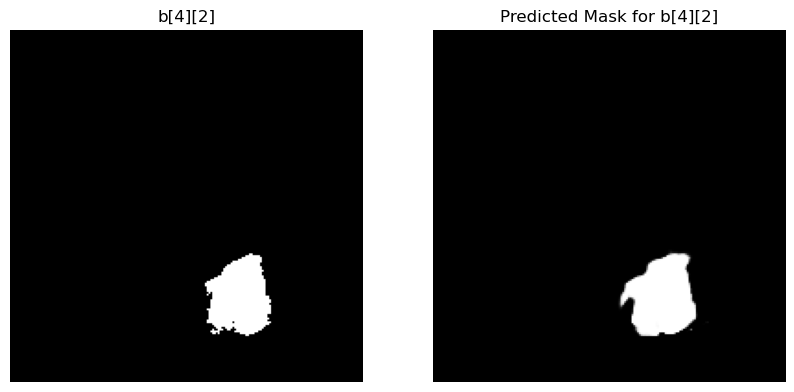

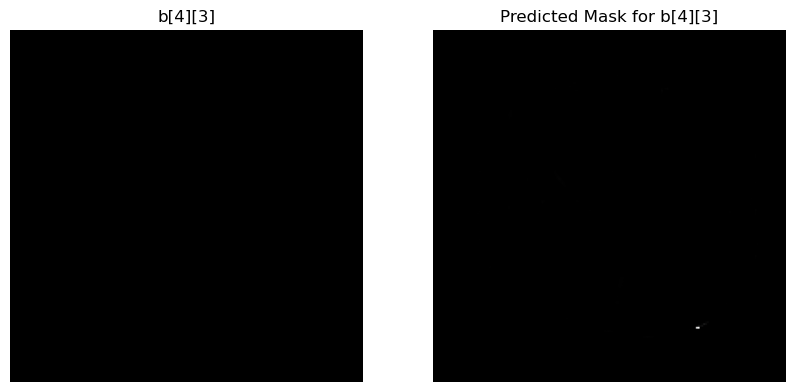

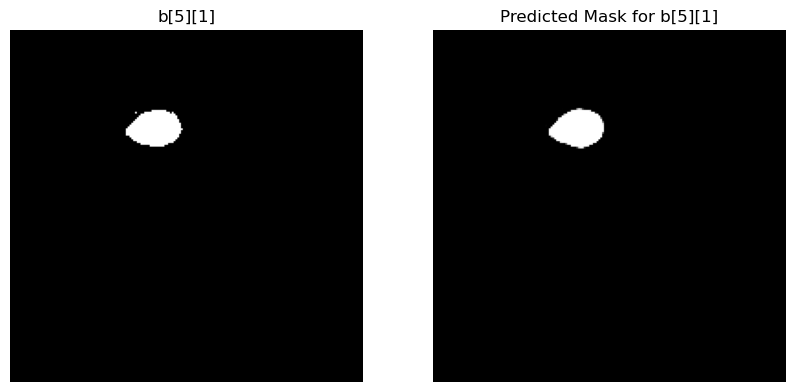

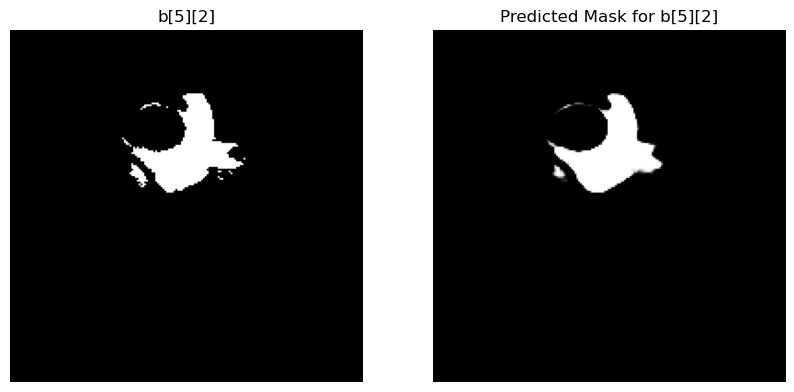

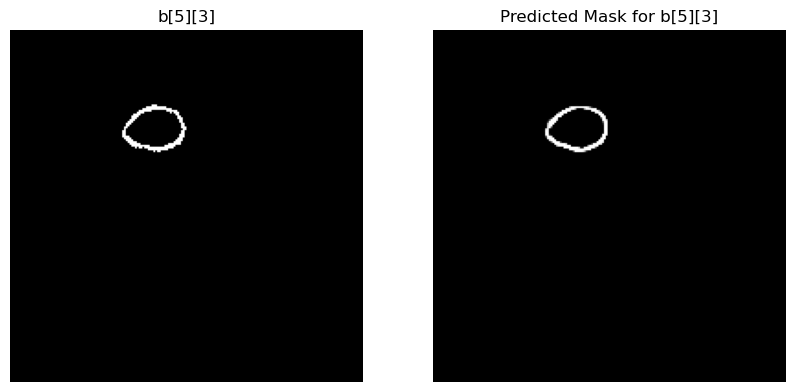

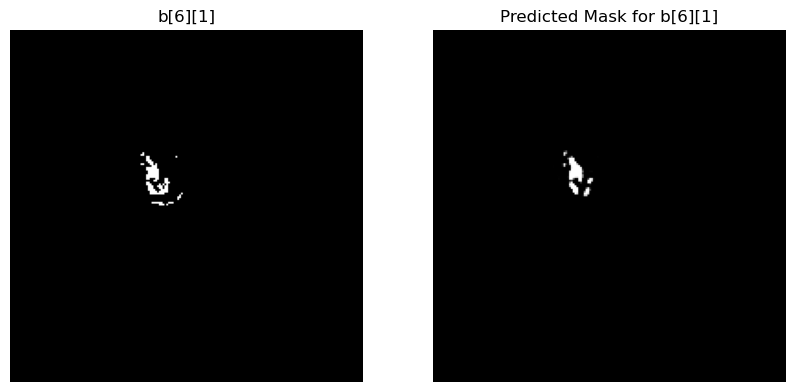

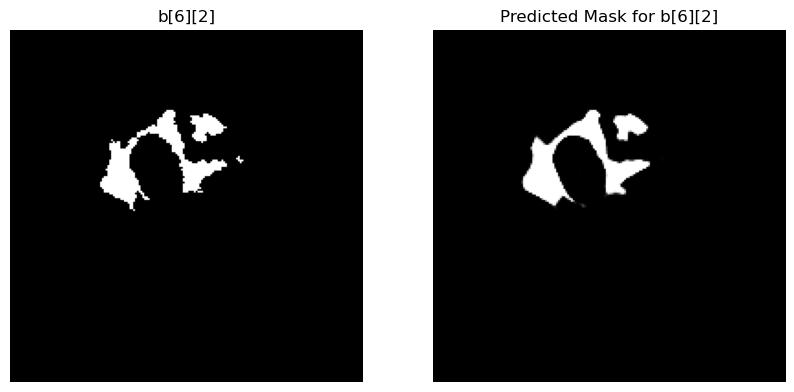

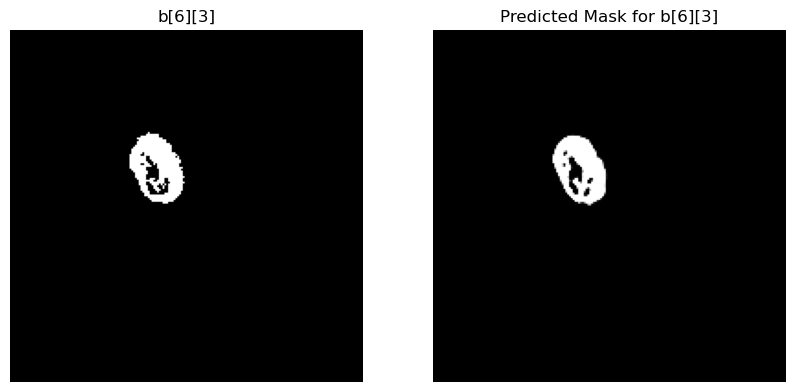

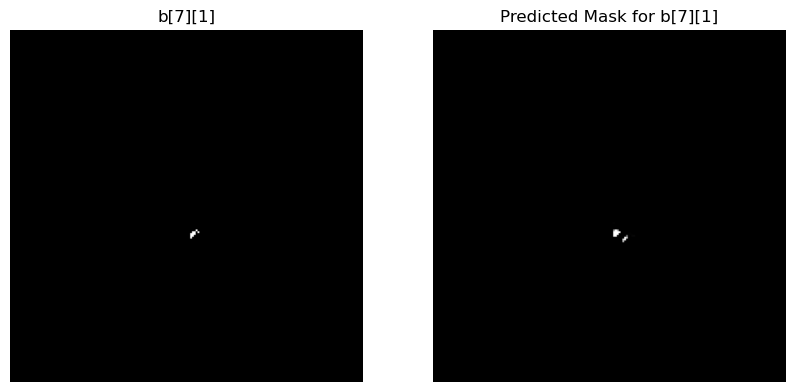

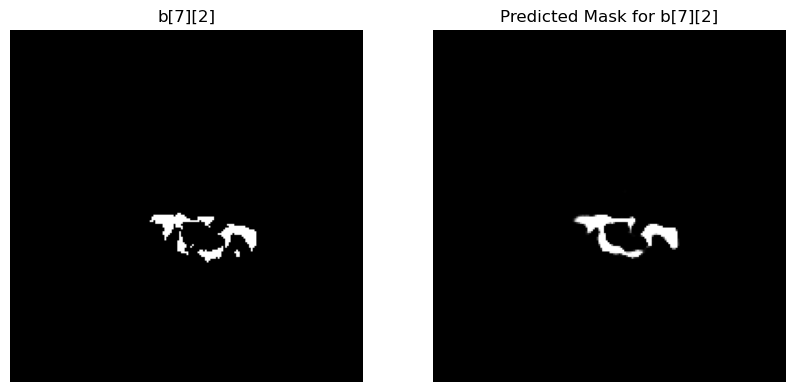

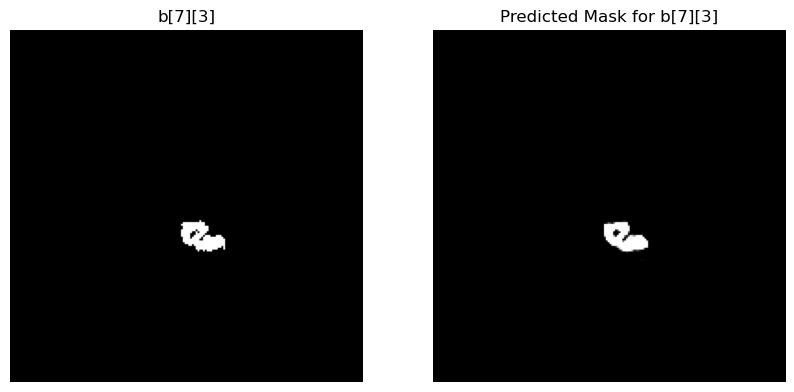

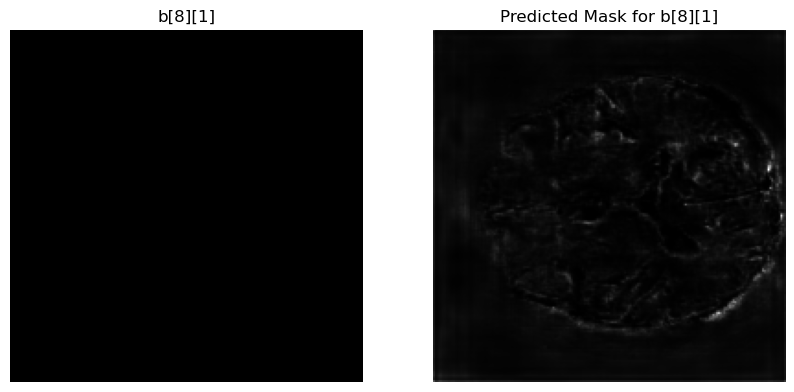

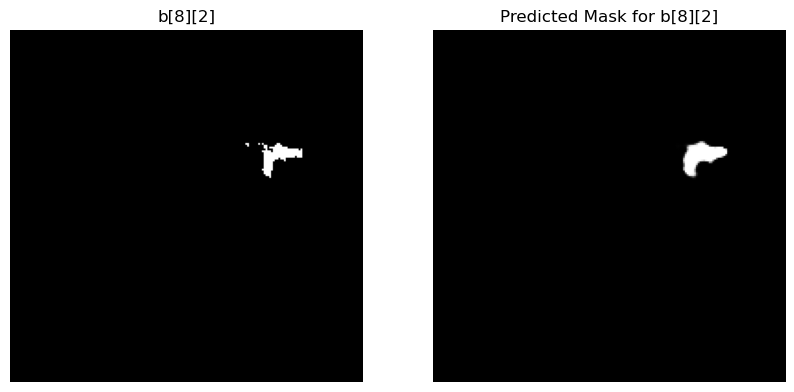

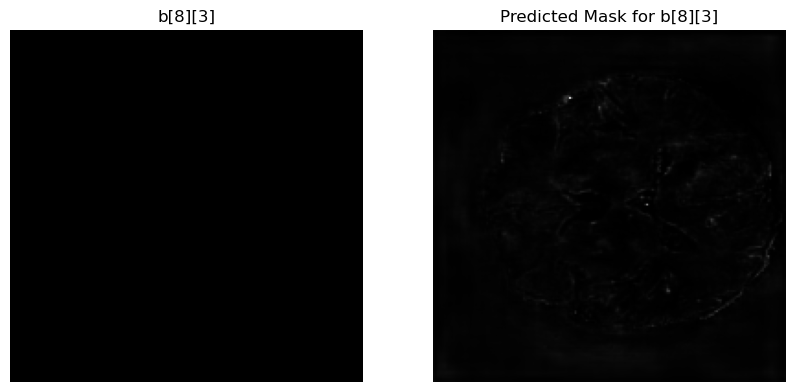

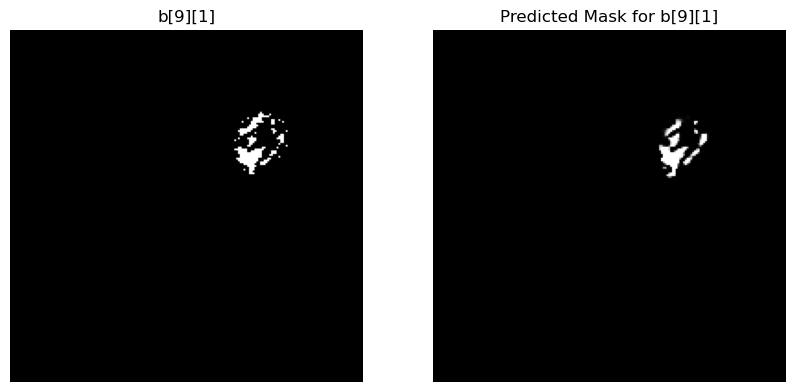

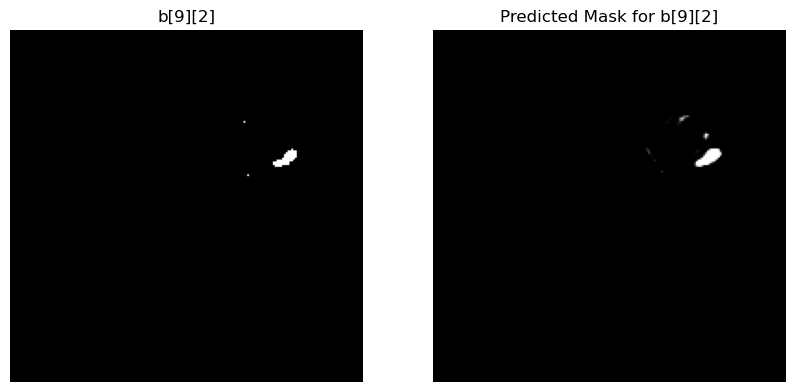

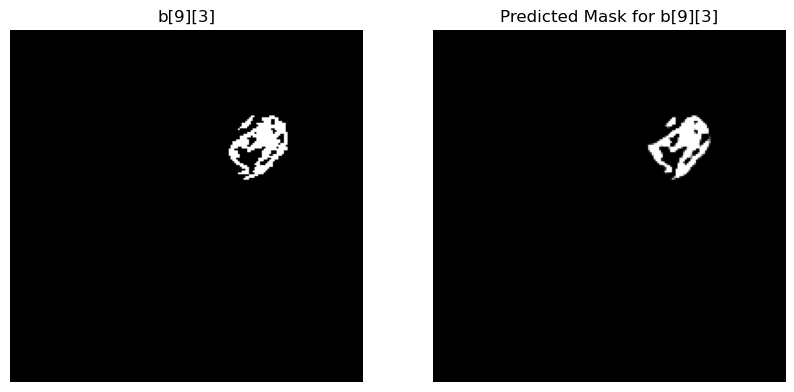

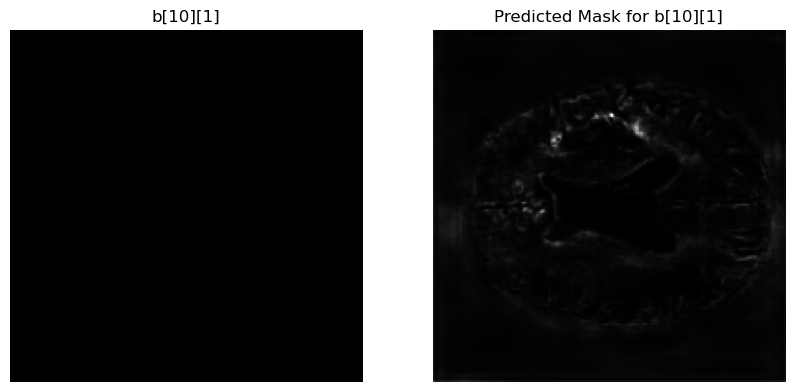

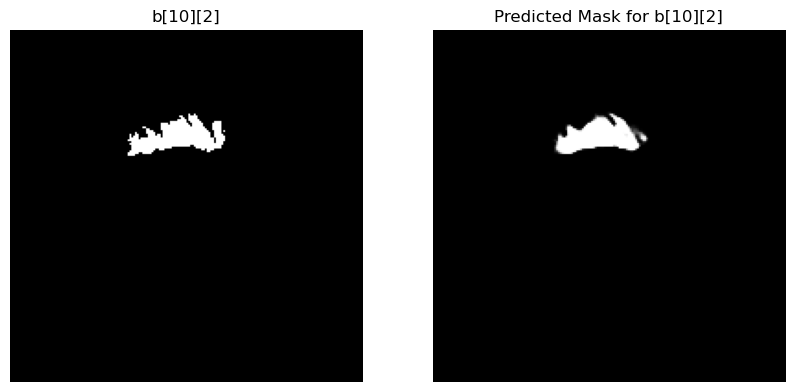

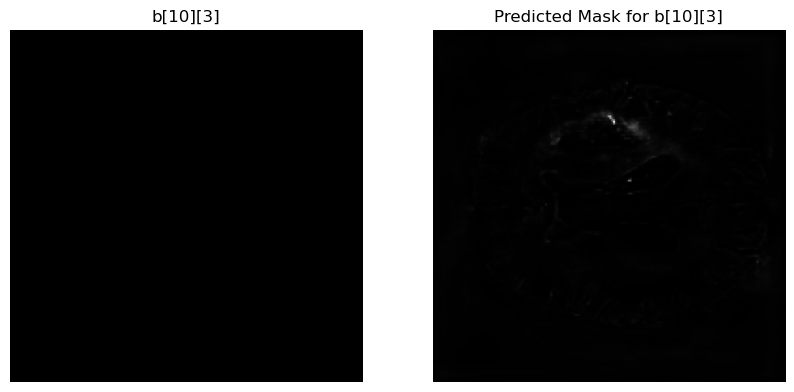

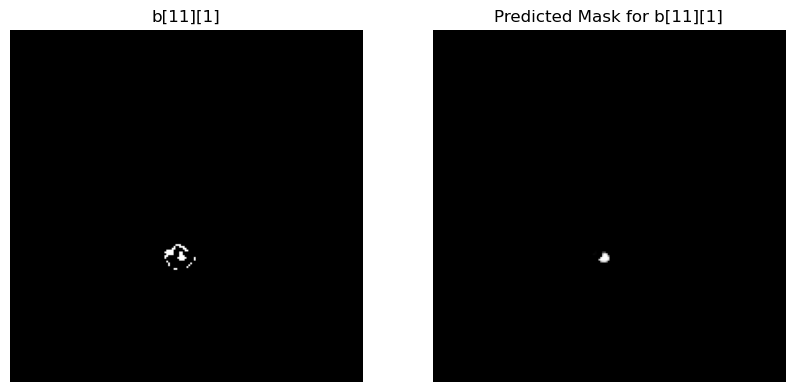

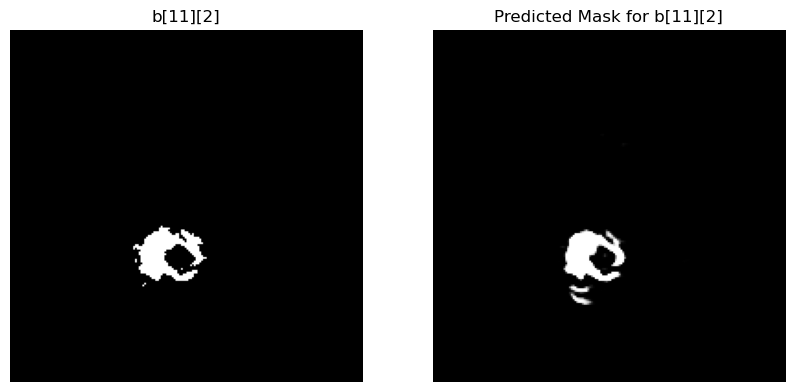

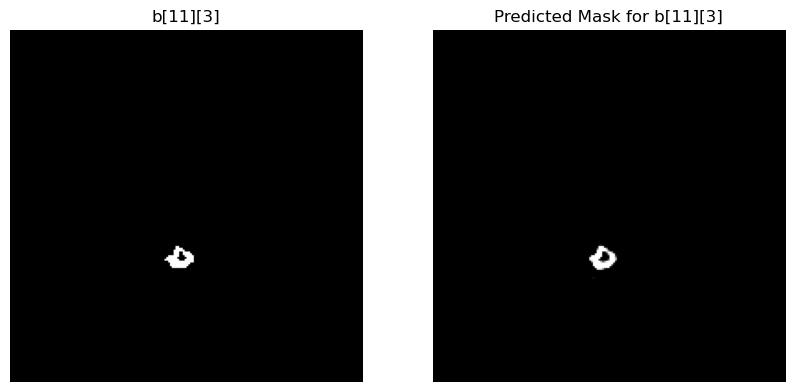

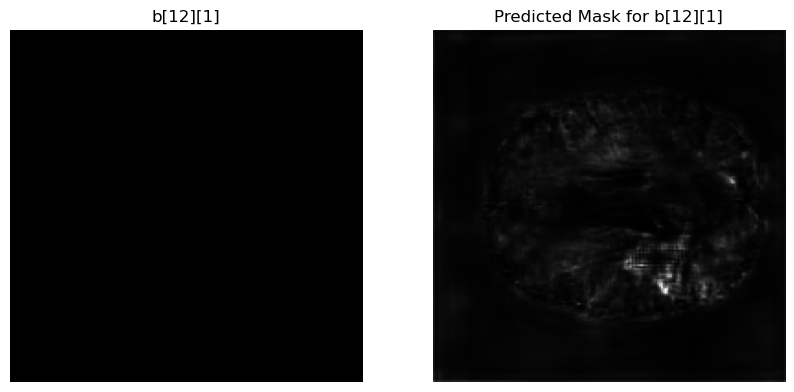

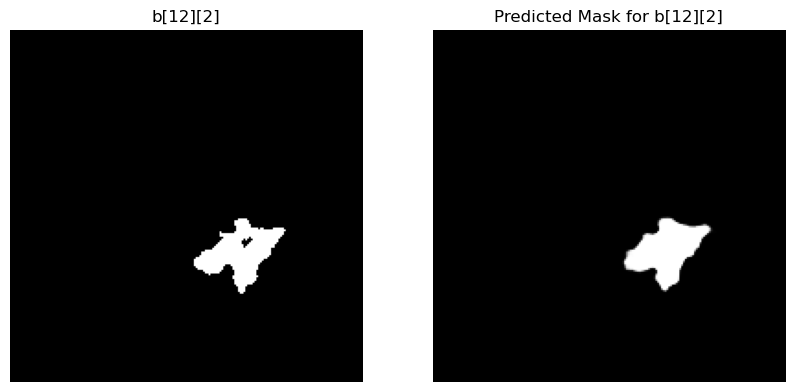

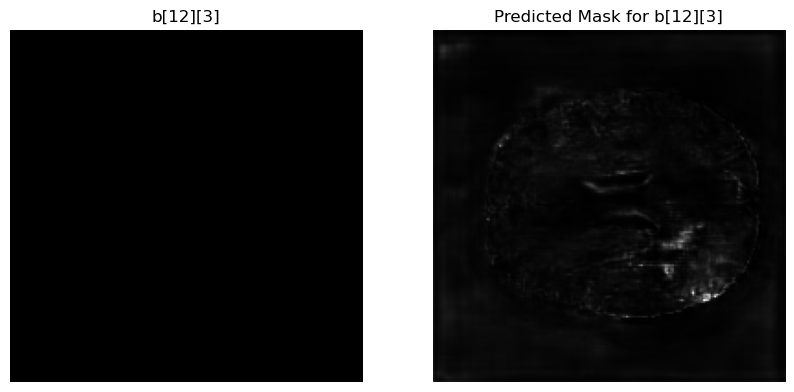

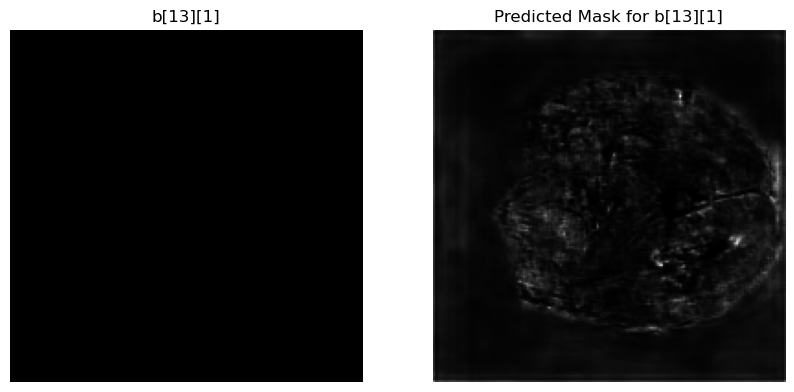

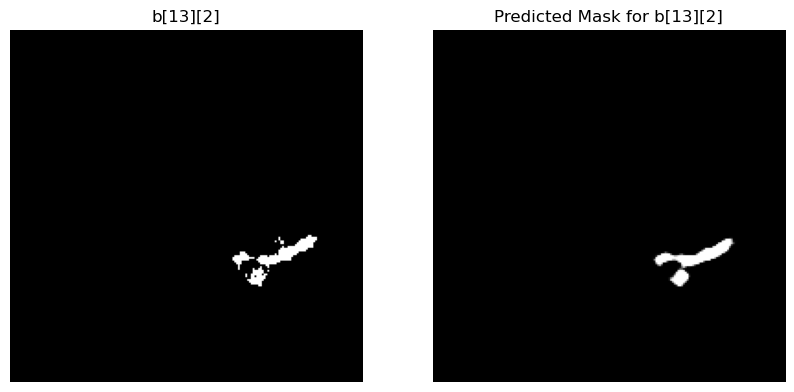

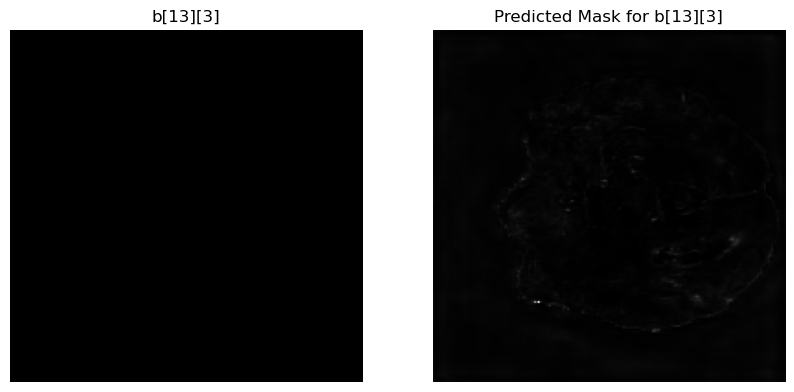

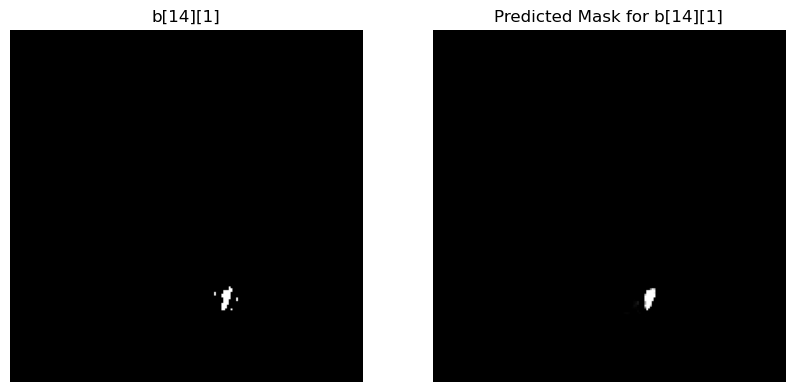

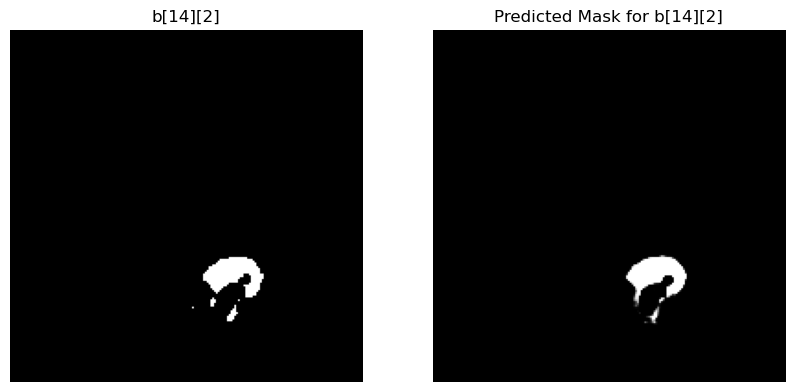

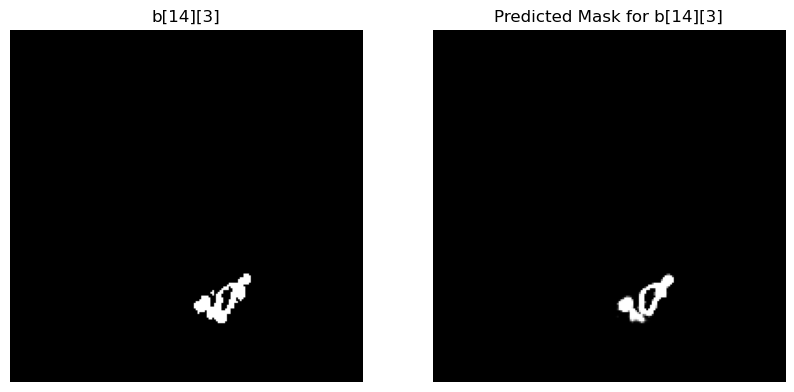

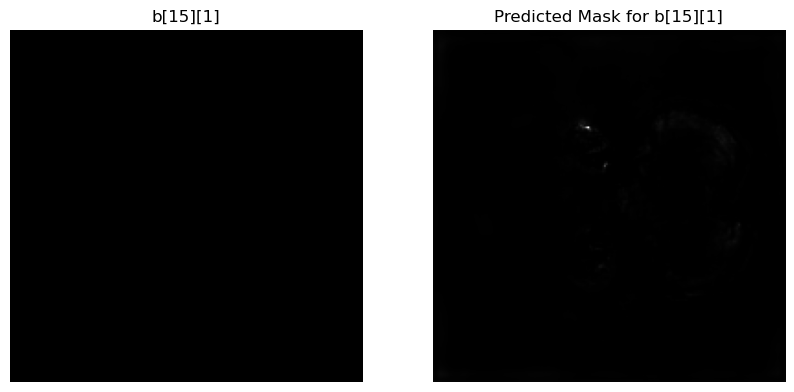

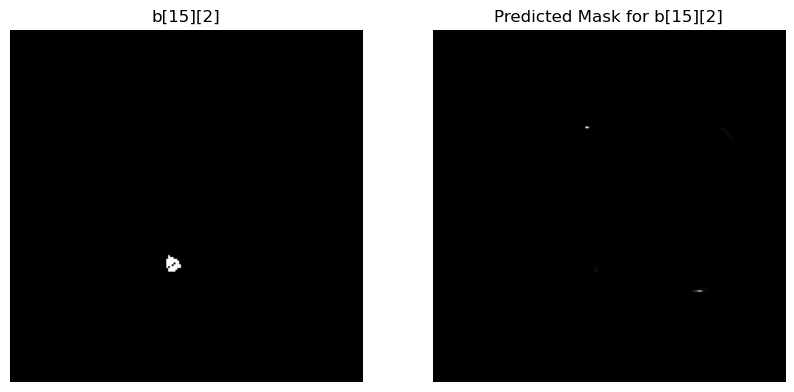

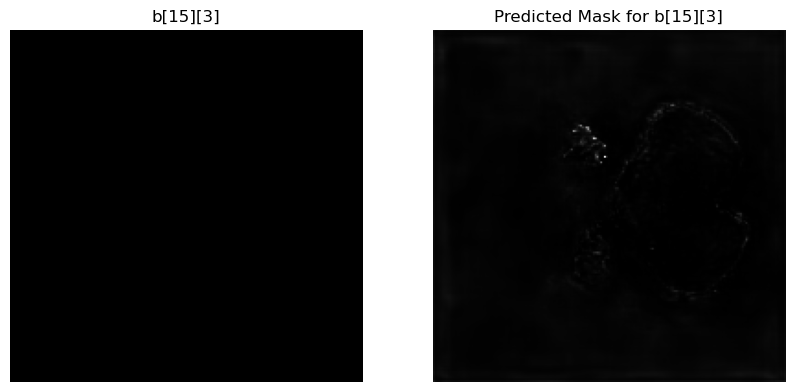

In [23]:
for i in range(1,len(b)):
    for j in range(1,len(b[i])):
        plt.figure(figsize=(10, 5))

        # Plot b[i][j]
        plt.subplot(1, 2, 1)
        plt.imshow(b[i][j], cmap="gray")
        plt.title(f"b[{i}][{j}]")
        plt.axis('off')

        # Plot predicted_mask_cpu[i][j]
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_mask_cpu[i][j], cmap="gray")
        plt.title(f"Predicted Mask for b[{i}][{j}]")
        plt.axis('off')

        plt.show()


In [21]:
def jaccard_coef_metric(probabilities, truth, treshold = 0.5, eps = 1e-9):

    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


model.eval()

with torch.no_grad():
    total_iou_score = 0.0
    num_samples = 0
    
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        output_logits = torch.sigmoid(outputs)
        
        pred_outputs = output_logits.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        
       
        iou_scores = jaccard_coef_metric(pred_outputs[:, 1:, ...], targets[:, 1:, ...])
        mean_iou_score = iou_scores.mean()
        
        total_iou_score += mean_iou_score.item() * inputs.size(0)
        num_samples += inputs.size(0)
        
    mean_iou_score = total_iou_score / num_samples
    print(f"Mean IoU score on test data: {mean_iou_score:.4f}")

Mean IoU score on test data: 0.6715
